This notebook demonstrates Kausal framework on ENSO with real data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import xarray as xr
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors
from matplotlib.collections import LineCollection
from tqdm import tqdm

from kausal.koopman import Kausal
from kausal import stats
from kausal.observables import RandomFourierFeatures, MLPFeatures


# 1. Load dynamics


We use ocean reanalysis dataset processed by https://leap-stc.github.io/ChaosBench/README.html

In [3]:
## CHANGE THIS TO YOUR OWN PATH
dataset_path = Path('/burg/glab/projects/ChaosBench/') 


/local/ipykernel_1169223/4195275838.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  omega = torch.tensor([all_sst, all_ssh])


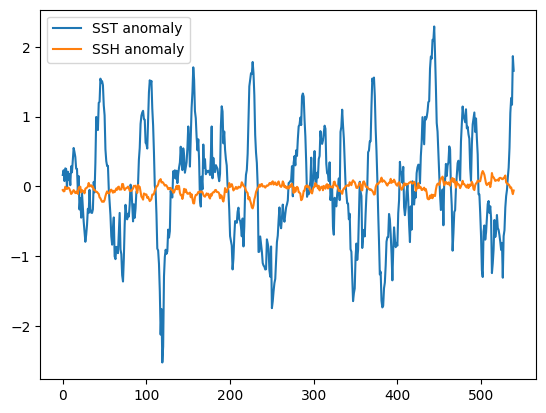

In [4]:
# Load dynamics
oras5_path = dataset_path / 'oras5'
oras5_files = list(oras5_path.glob("oras5_full_1.5deg_*01.zarr"))
oras5_files.sort()

# Load climatology
climatology_path = dataset_path / 'climatology' / 'climatology_oras5_spatial.zarr'
climatology_ds = xr.open_dataset(climatology_path, engine='zarr')

sst_clim = climatology_ds['mean'].sel(param='sosstsst').sel(lat=slice(5, -5), lon=slice(210, 270)).values[5::31]
ssh_clim = climatology_ds['mean'].sel(param='sossheig').sel(lat=slice(5, -5), lon=slice(150, 210)).values[5::31]
sst_anoms_clim = climatology_ds['mean'].sel(param='sosstsst').sel(lat=slice(5, -5), lon=slice(190, 240)).values[5::31]

# Pre-process data
all_sst, all_ssh, all_sst_anoms = [], [], []

for i, oras5_file in enumerate(oras5_files):
    ds = xr.open_dataset(oras5_file, engine='zarr')
    sst = ds['sosstsst'].sel(latitude=slice(5, -5), longitude=slice(210, 270)).values ## Eastern Pacific
    ssh = ds['sossheig'].sel(latitude=slice(5, -5), longitude=slice(150, 210)).values ## Western Pacific
    sst_anoms = ds['sosstsst'].sel(latitude=slice(5, -5), longitude=slice(190, 240)).values ## Nino34 Region

    ## Compute monthly anomalies
    sst = sst[None, ] - sst_clim[i % 12]
    ssh = ssh[None, ] - ssh_clim[i % 12]
    sst_anoms = sst_anoms[None, ] - sst_anoms_clim[i % 12]
    
    all_sst.append(sst.flatten())
    all_ssh.append(ssh.flatten())
    all_sst_anoms.append(sst_anoms.flatten())
    
# Post-process data
omega = torch.tensor([all_sst, all_ssh])
omega = omega.permute(0,2,1).float()

# Plot timeseries on one grid cell
plt.plot(omega[0,0], label='SST anomaly')
plt.plot(omega[1,0], label='SSH anomaly')
plt.legend()
plt.show();


In [5]:
# Additional parameters and helper functions
plt.rcParams.update({
    "font.size": 14,                # General font size
    "axes.titlesize": 16,           # Title font size
    "axes.labelsize": 16,           # Axis label font size
    "xtick.labelsize": 12,          # X-axis tick label size
    "ytick.labelsize": 12,          # Y-axis tick label size
    "legend.fontsize": 16,          # Legend font size
    "lines.linewidth": 3,           # Line width
    "figure.dpi": 300,              # Higher DPI for clearer output
})

# Shading ENSO event function (based on SST anomalies in the Nino3.4 region)
def plot_anomalies_bg(ax, sst_anomalies, time_idx):
    """
    Plot El Niño and La Niña events with 5 consecutive 3-month running mean criterion.
    """
    
    elnino_threshold, lanina_threshold = 0.5, -0.5
    elnino_label, lanina_label = False, False

    # Calculate 3-month running mean
    running_mean = np.convolve(sst_anomalies, np.ones(3) / 3, mode='valid')

    # Check for 5 consecutive values exceeding the El Nino or La Nina threshold
    for i in range(len(running_mean) - 4):
        
        ## El Nino
        if all(running_mean[i:i + 5] >= elnino_threshold):
            ax.axvspan(
                time_idx[i + 2], time_idx[i + 3] if i + 5 < len(time_idx) else time_idx[-1],
                color='C1', alpha=0.2, label='El Niño' if not elnino_label else None
            )
            elnino_label = True


        ## La Nina
        elif all(running_mean[i:i + 5] <= lanina_threshold):
            ax.axvspan(
                time_idx[i + 2], time_idx[i + 3] if i + 5 < len(time_idx) else time_idx[-1],
                color='C0', alpha=0.2, label='La Niña' if not lanina_label else None
            )
            lanina_label = True

    ax.legend(loc='upper left', frameon=True)

# Normalizing function
normalize_fn = lambda x: x / torch.max(torch.abs(x))


# 2. Causal Koopman

100%|████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:51<00:00, 10.53it/s]


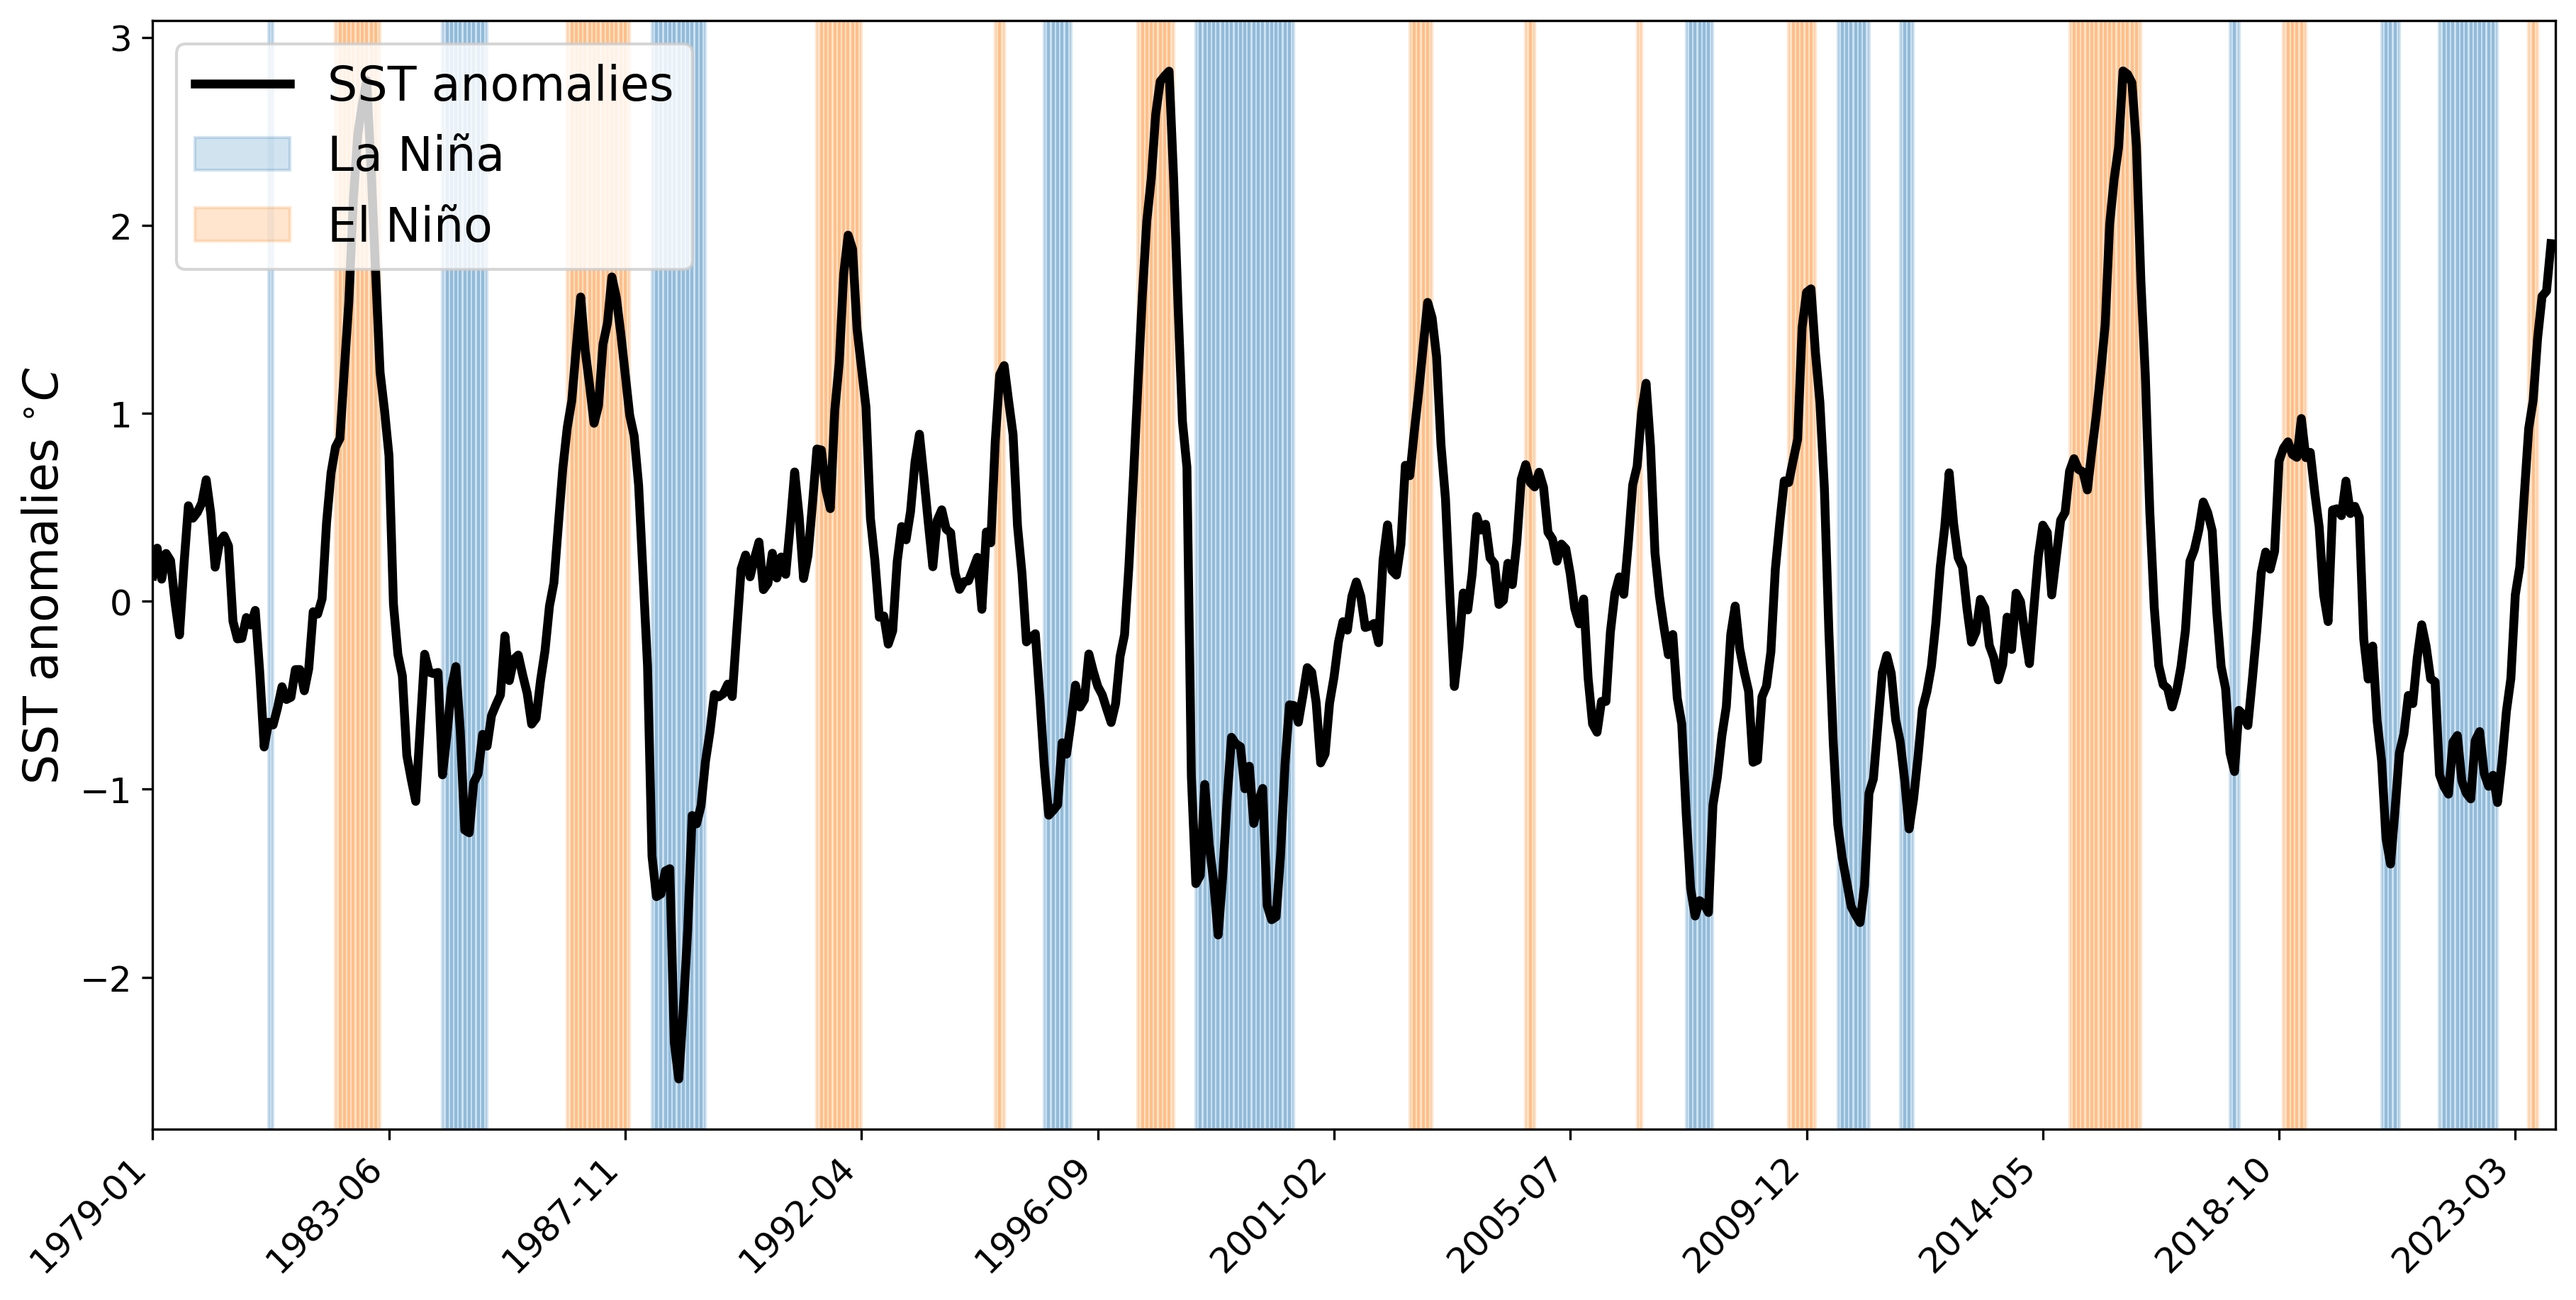

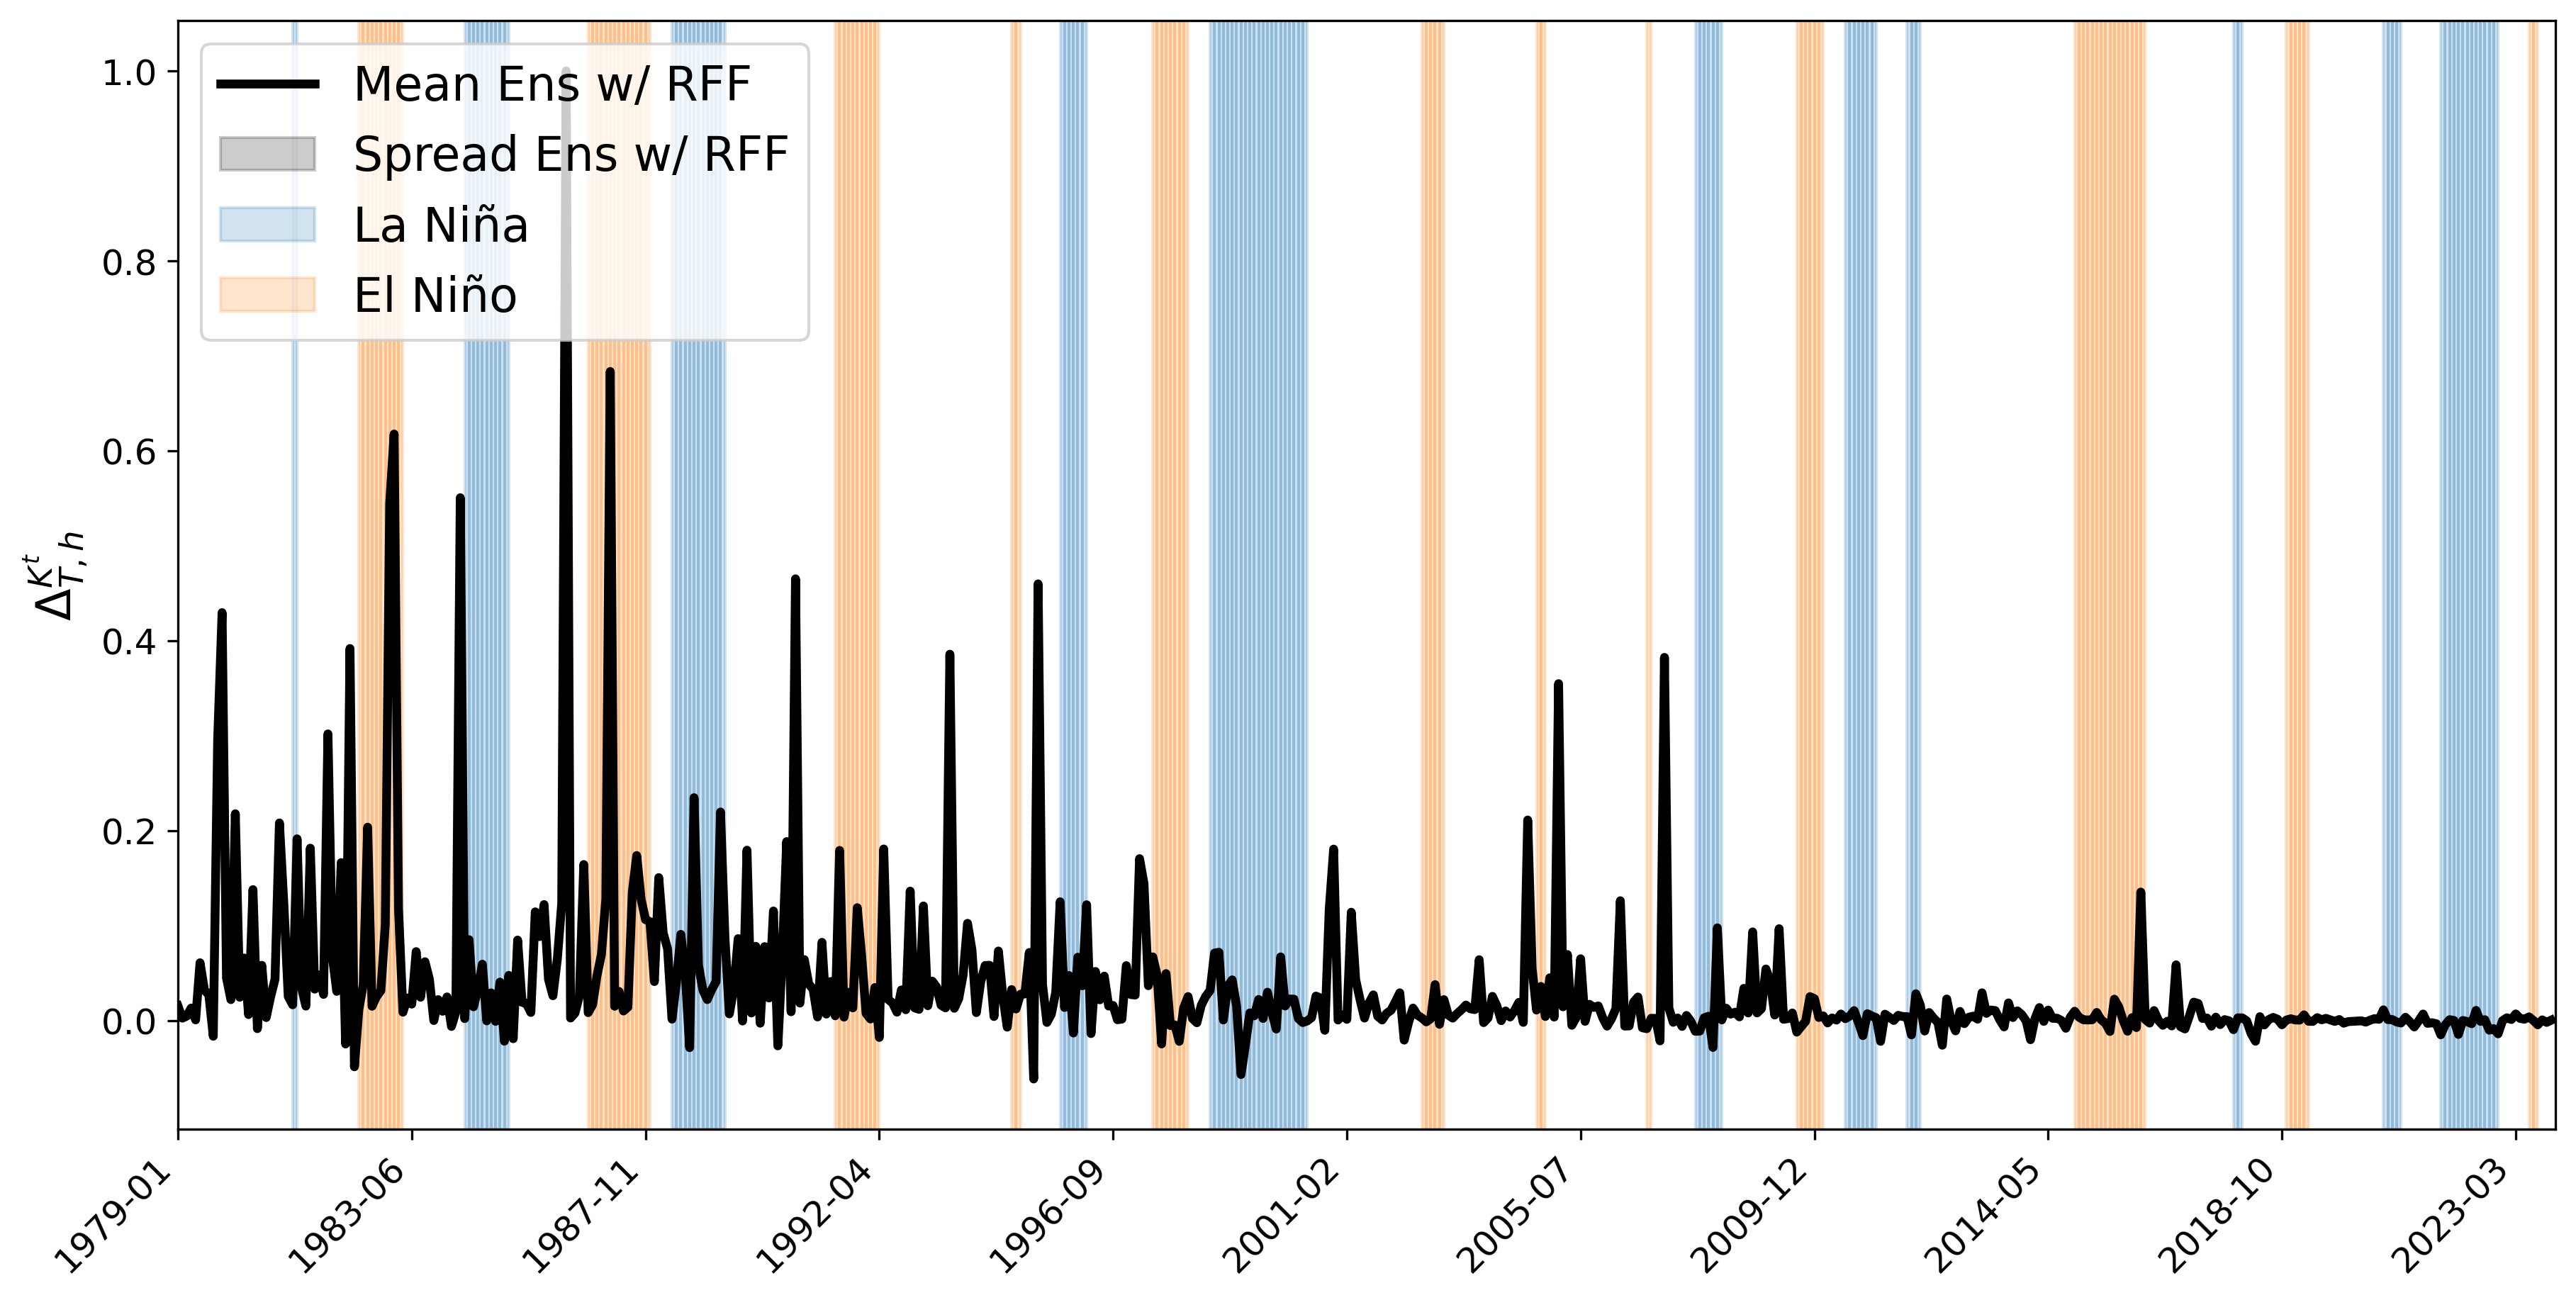

In [6]:
# Causal inference (full)
time_shifts = torch.arange(1, 540, 1)
time_idx = torch.arange(len(time_shifts))

# Hyperparameters
n_members = 5

# Cause and effect
cause = omega[0]  ## T
effect = omega[1] ## h

time_to_evals = {0: "1979-01"}
for time_start, start_date in time_to_evals.items():
    dates = pd.date_range(start=start_date, periods=len(time_shifts), freq='ME')
    sst_anomalies = torch.tensor(all_sst_anoms).T.mean(axis=0)[time_idx + time_start]
    
    # Initialize causal Koopman model
    causal_effect_rff = []
    
    for _ in range(n_members):
        causal_koopman = Kausal(
            marginal_observable = RandomFourierFeatures(M=1024),
            joint_observable = RandomFourierFeatures(M=1024),
            cause = cause, effect = effect,
        )
        
        # Perform multistep causal analysis
        causal_effect_rff.append(
            causal_koopman.evaluate_multistep(time_shifts = time_shifts,  init_idx = time_start)
        )
    
    # Plot
    # Subfigure 1: SST anomalies with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    ax.plot(sst_anomalies, label='SST anomalies', color='black')
    ax.set_ylabel(r'SST anomalies $^{\circ}C$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_bg(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    f.savefig("docs/enso_sst_anomalies.png", dpi=300, bbox_inches="tight")
    
    # Subfigure 2: Causal effect with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    causal_effect_rff = normalize_fn(torch.stack(causal_effect_rff))
    ax.plot(causal_effect_rff.mean(axis=0), color='black', label='Mean Ens w/ RFF')
    ax.fill_between(
        time_idx,
        causal_effect_rff.mean(axis=0) - causal_effect_rff.std(axis=0),
        causal_effect_rff.mean(axis=0) + causal_effect_rff.std(axis=0),
        color=f'black',
        alpha=0.2,
        label=r'Spread Ens w/ RFF'
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_bg(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    f.savefig("docs/enso_real_rff_expanded.png", dpi=300, bbox_inches="tight");


# 3. Deep Causal Koopman

100%|████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:38<00:00, 13.84it/s]


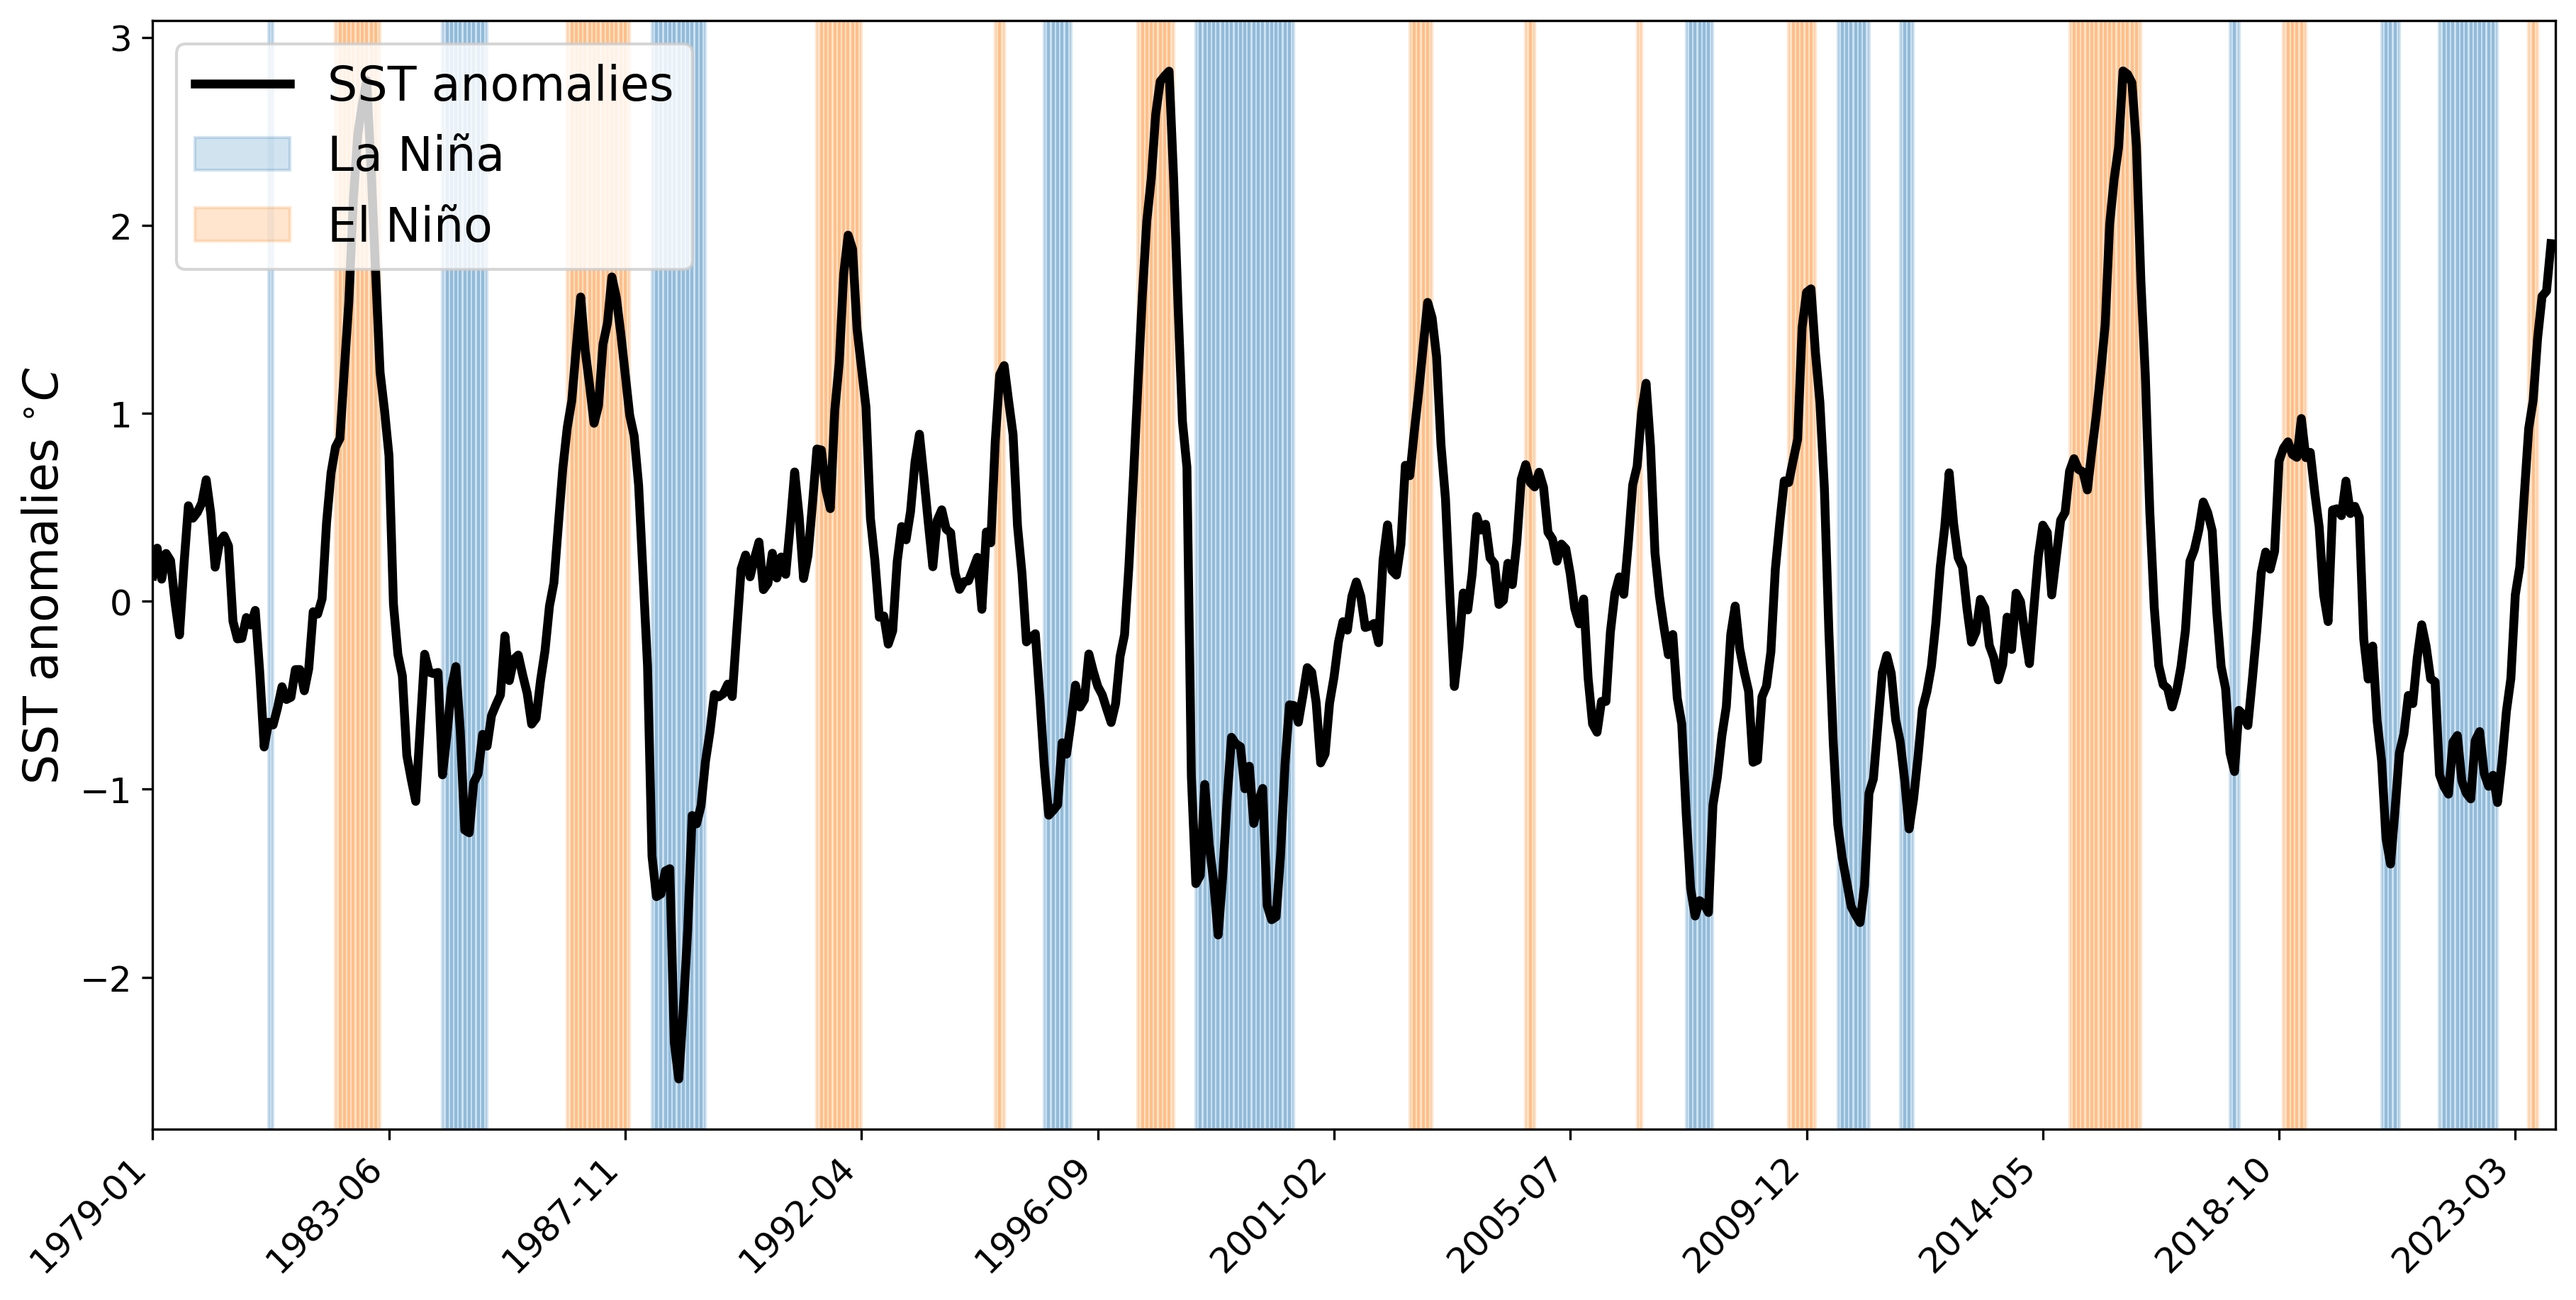

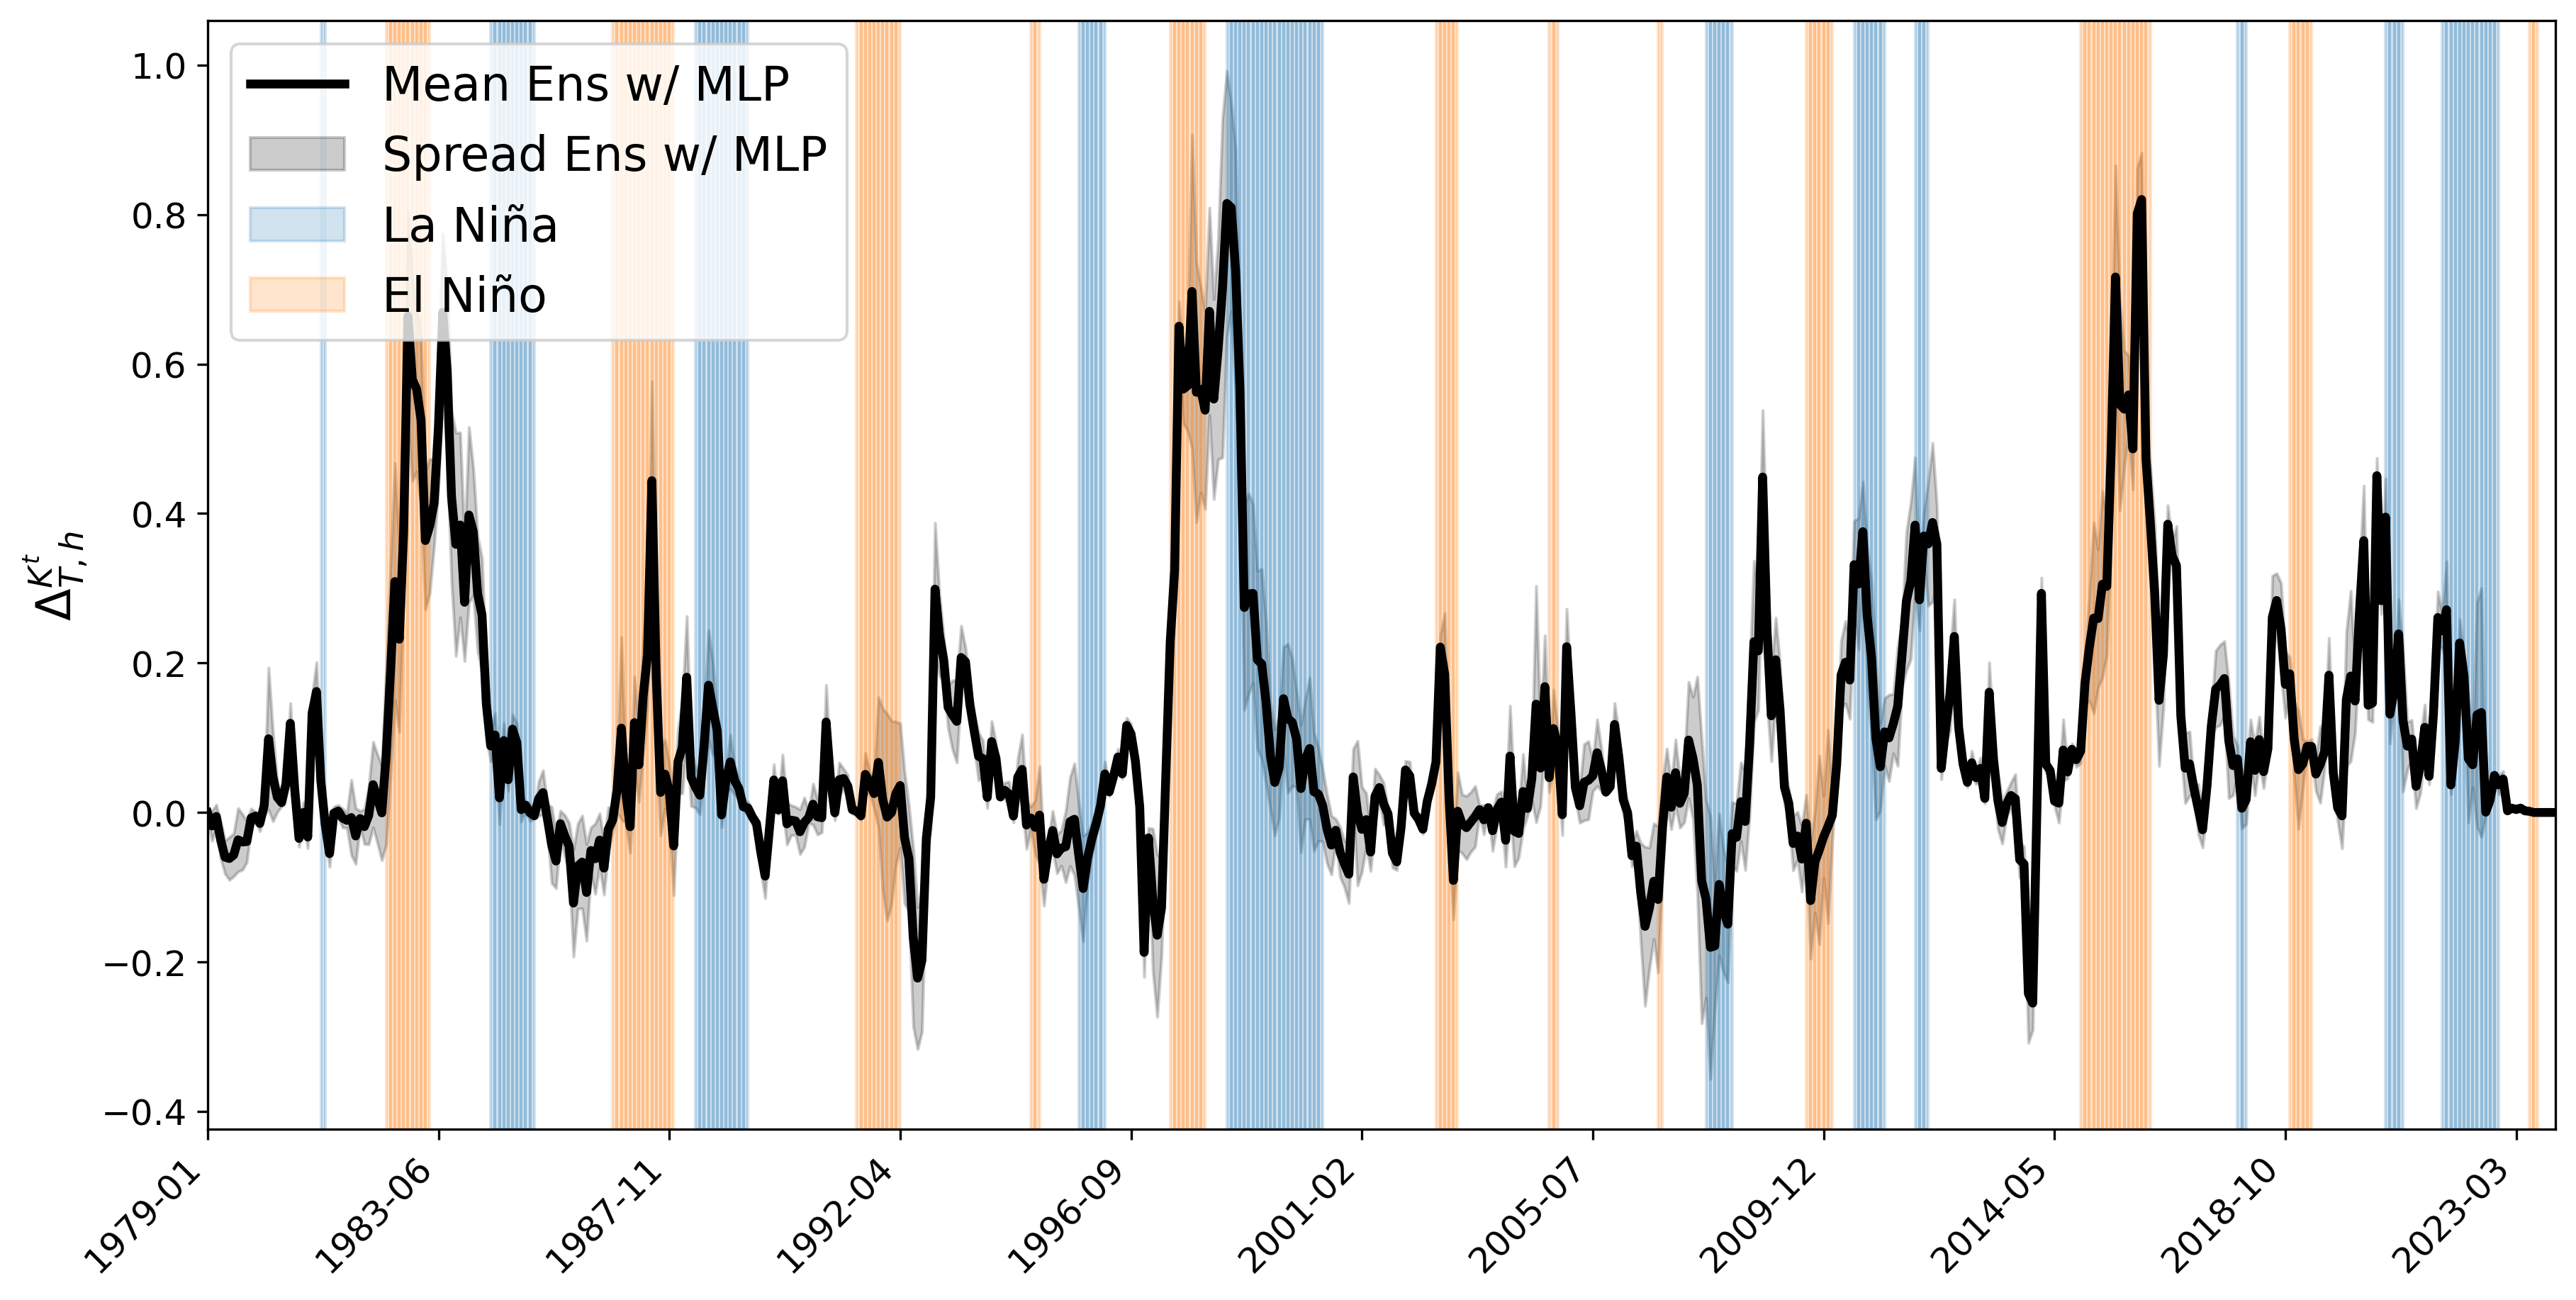

In [7]:
# Causal inference (full)
time_shifts = torch.arange(1, 540, 1)
time_idx = torch.arange(len(time_shifts))

# Hyperparameters
n_members = 5
hidden_channels = [512, 1024]
lr = 1e-2
epochs = 500
n_train = len(oras5_files)

# Cause and effect
cause = omega[0]  ## T
effect = omega[1] ## h

time_to_evals = {0: "1979-01"}
for time_start, start_date in time_to_evals.items():
    dates = pd.date_range(start=start_date, periods=len(time_shifts), freq='ME')
    sst_anomalies = torch.tensor(all_sst_anoms).T.mean(axis=0)[time_idx + time_start]
    
    # Initialize causal Koopman model
    causal_effect_mlp = []
    
    for _ in range(n_members):
        causal_koopman = Kausal(
            marginal_observable = MLPFeatures(
                in_channels=effect.shape[0], hidden_channels = hidden_channels, out_channels=effect.shape[0]
            ),
            
            joint_observable = MLPFeatures(
                in_channels=effect.shape[0] + cause.shape[0], hidden_channels=hidden_channels, out_channels=effect.shape[0]
            ),
            
            cause = cause, effect = effect,
        )
        
        # Fit the observable functions
        _, _ = causal_koopman.fit(n_train=n_train, epochs=epochs, lr=lr, batch_size=n_train)
        
        # Perform multistep causal analysis
        with torch.no_grad():
            causal_effect_mlp.append(
                causal_koopman.evaluate_multistep(time_shifts = time_shifts,  init_idx = time_start)
            )
    
    # Plot
    # Figure 1: SST anomalies with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    ax.plot(sst_anomalies, label='SST anomalies', color='black')
    ax.set_ylabel(r'SST anomalies $^{\circ}C$', fontsize=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_bg(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    f.savefig("docs/enso_sst_anomalies.png", dpi=300, bbox_inches="tight")
    
    # Subfigure 2: Causal effect with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    causal_effect_mlp = normalize_fn(torch.stack(causal_effect_mlp))
    ax.plot(causal_effect_mlp.mean(axis=0), color='black', label='Mean Ens w/ MLP')
    ax.fill_between(
        time_idx,
        causal_effect_mlp.mean(axis=0) - causal_effect_mlp.std(axis=0),
        causal_effect_mlp.mean(axis=0) + causal_effect_mlp.std(axis=0),
        color=f'black',
        alpha=0.2,
        label=r'Spread Ens w/ MLP'
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', fontsize=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_bg(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    f.savefig("docs/enso_real_mlp_expanded.png", dpi=300, bbox_inches="tight");


# 4. Additional Experiments

For simplicity, we overlay causal measures between RFF and MLP.

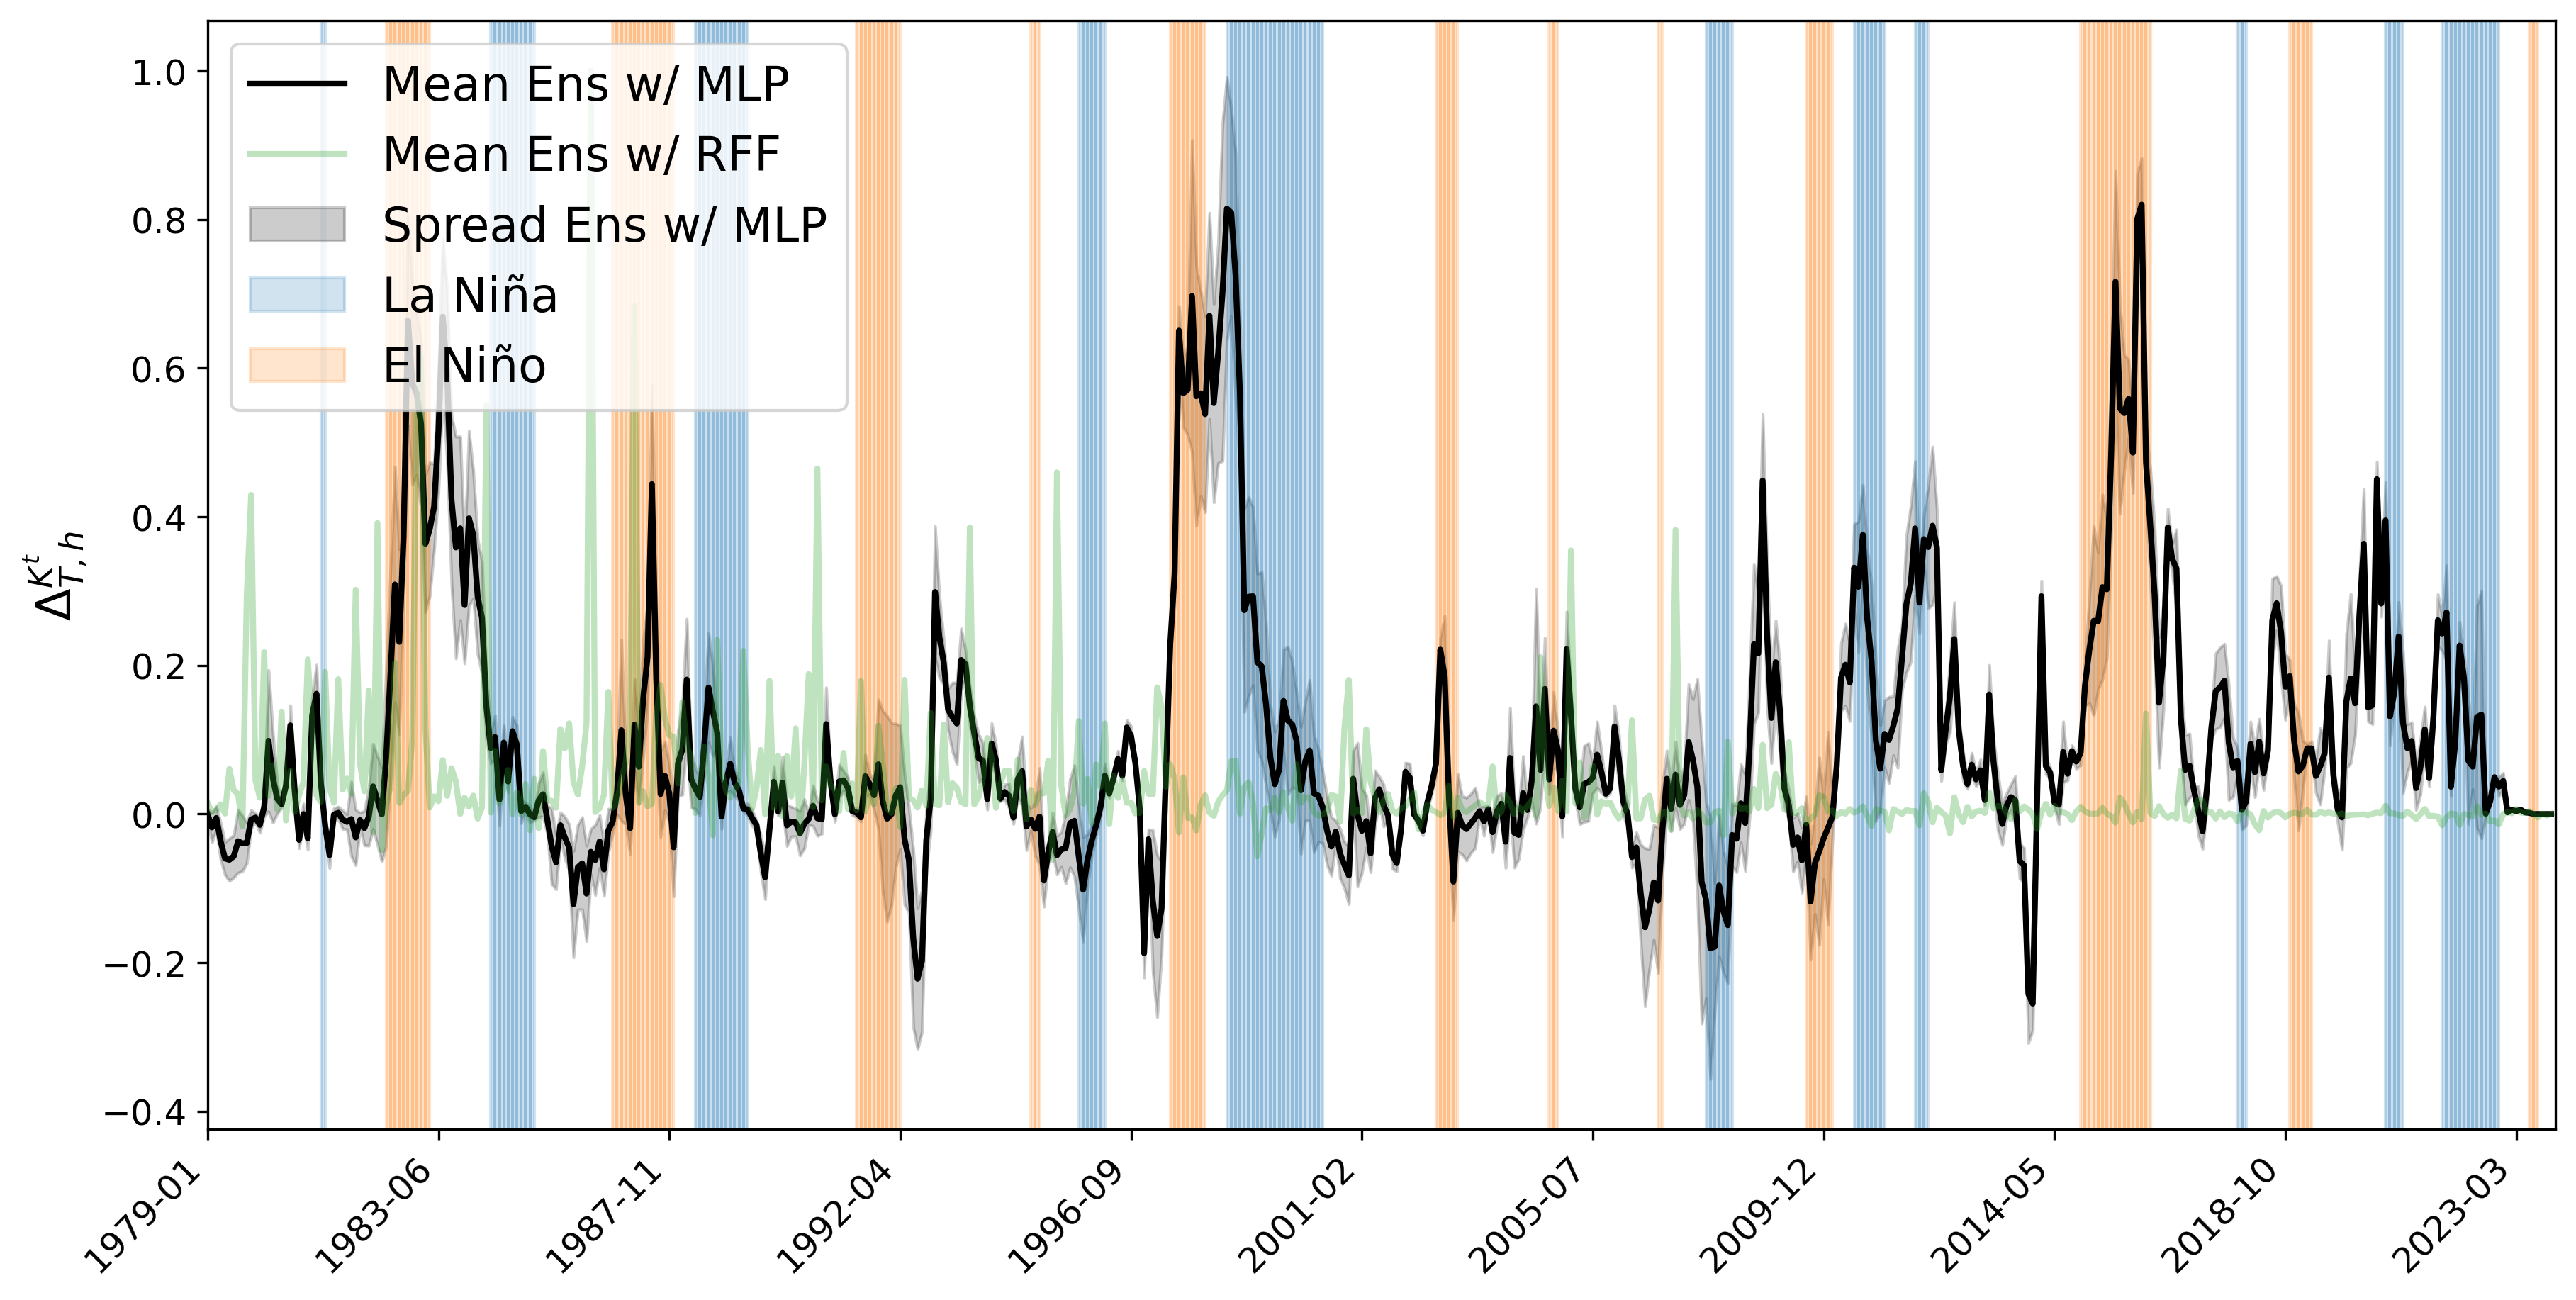

In [8]:
# Overlaying both plots above
f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
ax.plot(causal_effect_mlp.mean(axis=0), color='black', linestyle='solid', alpha=1.0, label='Mean Ens w/ MLP', linewidth=2)
ax.plot(causal_effect_rff.mean(axis=0), color='C2', linestyle='solid', alpha=0.3, label='Mean Ens w/ RFF', linewidth=2)
ax.fill_between(
    time_idx,
    causal_effect_mlp.mean(axis=0) - causal_effect_mlp.std(axis=0),
    causal_effect_mlp.mean(axis=0) + causal_effect_mlp.std(axis=0),
    color=f'black',
    alpha=0.2,
    label=r'Spread Ens w/ MLP'
)

ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
ax.set_xlim([time_shifts[0], time_shifts[-1]])
ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
plot_anomalies_bg(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
f.savefig("docs/enso_real_rff_mlp.png", dpi=300, bbox_inches="tight");
